<img src="images/dask_horizontal.svg"
     width="45%"
     alt="Dask logo\">

# Dask DataFrame

In the last exercise in the Dask Delayed notebook, we wrote a function which used `dask.delayed` to parallelize loading multiple CSV files into a Pandas DataFrame. In this notebook, we'll introduce and use Dask's DataFrame interface to automatically build similiar parallel computations for tabular data computations. Dask DataFrames look and feel like Pandas DataFrames, but they run on the same infrastructure that powers `dask.delayed`.

## The Dask DataFrame data model

For the most part, a Dask DataFrame feels like a Pandas DataFrame. However, internally a Dask DataFrame is composed of many Pandas DataFrames (see the image below). 

<img src="http://dask.pydata.org/en/latest/_images/dask-dataframe.svg" width="30%">

Dask DataFrames are partitioned along their index into different **partitions** where each parition is a normal Pandas DataFrame. These Pandas objects may live on disk or on other machines.

Dask DataFrames implement a well-used portion of the Pandas API which are backed by blocked algorithms that allow for parallel and out-of-core computation. In particular, Dask DataFrames support:

- Elementwise operations: `df.x` + `df.y`, `df * df`

- Row-wise selections: `df[df.x > 0]`

- Loc: `df.loc[4.0:10.5]`

- Common aggregations: `df.x.max()`, `df.max()`

- Is in: `df[df.x.isin([1, 2, 3])]`

- Datetime/string accessors: `df.timestamp.month`

- Froupby-aggregate (with common aggregations): `df.groupby(df.x).y.max()`, `df.groupby('x').max()`

- ...

See the [Dask DataFrame API docs](http://docs.dask.org/en/latest/dataframe-api.html) for full details about what portion of the Pandas API is implemented for Dask DataFrames.

For many purposes Dask DataFrames can serve as drop-in replacements for Pandas DataFrames. Much like the Dask Delayed interface, Dask DataFrames are lazily evaluated. You can use use the DataFrame API to automatically build up a task graph representing complex computations and then call `compute()` to to evaluate the graph in parallel. 

## When to use Dask DataFrames

Pandas is great for tabular datasets that fit in memory. If your data fits in memory then you should use Pandas. **Dask becomes useful when the dataset you want to analyze is larger than your machine's RAM** where you would normally run into `MemoryError`s.

```python
    MemoryError:  ...
```

During this tutorial, the example NYC dataset we're working with is only about 200MB so that you can download it in a reasonable time and exercises finish quickly, but Dask Dataframes will scale to datasets much larger than the memory on your local machine. Furthermore, as we'll talk about in the next notebook, Dask's distributed scheduler allows you to run the same DataFrame computation across a cluster.

# Getting started with Dask DataFrames

Let's use Dask DataFrame's to explore our NYC flight dataset. Dask's `read_csv` function will automatically example wildcard characters like `"*"` which can, for example, be used to load an entire directory of CSV files.

In [1]:
%run prep.py -d flights

In [2]:
import os

files = os.path.join('data', 'nycflights', '*.csv')
files

'data\\nycflights\\*.csv'

In [3]:
import dask.dataframe as dd

df = dd.read_csv(files,
                 parse_dates={'Date': [0, 1, 2]},
                 dtype={"TailNum": str,
                        "CRSElapsedTime": float,
                        "Cancelled": bool})
df

,Date,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,Diverted
npartitions=10,,,,,,,,,,,,,,,,,,,,,
,datetime64[ns],int64,float64,int64,float64,int64,object,int64,object,float64,float64,float64,float64,float64,object,object,float64,float64,float64,bool,int64
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


Notice that the respresentation of the dataframe object contains no data - Dask has just done enough to read the start of the first file, and infer the column names and dtypes.

In [4]:
df.columns

Index(['Date', 'DayOfWeek', 'DepTime', 'CRSDepTime', 'ArrTime', 'CRSArrTime',
       'UniqueCarrier', 'FlightNum', 'TailNum', 'ActualElapsedTime',
       'CRSElapsedTime', 'AirTime', 'ArrDelay', 'DepDelay', 'Origin', 'Dest',
       'Distance', 'TaxiIn', 'TaxiOut', 'Cancelled', 'Diverted'],
      dtype='object')

In [5]:
df.dtypes

Date                 datetime64[ns]
DayOfWeek                     int64
DepTime                     float64
CRSDepTime                    int64
ArrTime                     float64
CRSArrTime                    int64
UniqueCarrier                object
FlightNum                     int64
TailNum                      object
ActualElapsedTime           float64
CRSElapsedTime              float64
AirTime                     float64
ArrDelay                    float64
DepDelay                    float64
Origin                       object
Dest                         object
Distance                    float64
TaxiIn                      float64
TaxiOut                     float64
Cancelled                      bool
Diverted                      int64
dtype: object

Dask DataFrames have an `.npartitions` attribute which tells you how many Pandas DataFrames make up a Dask DataFrame.

In [6]:
df.npartitions

10

Let's look at the task graph for our Dask DataFrame to get a sense for where these paritions are coming from:

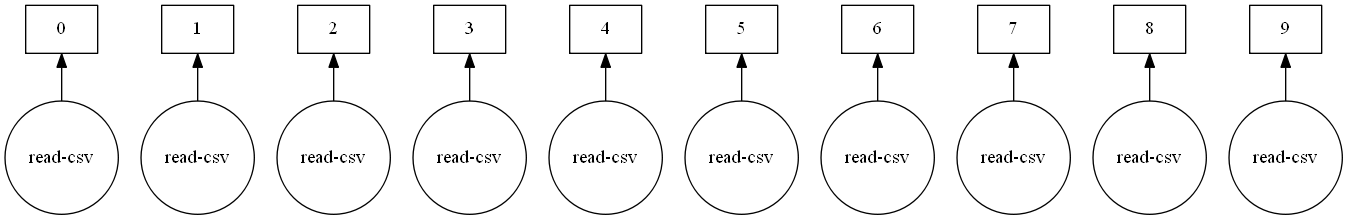

In [7]:
df.visualize()

Each paritition in our Dask DataFrame is the result of calling Pandas' `read_csv` on an input CSV file in our dataset.

We can view the start of the data with `df.head()`

In [8]:
df.head()

,Date,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,...,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,Diverted
0,1990-01-01,1,1621.0,1540,1747.0,1701,US,33,NaN,86.0,...,NaN,46.0,41.0,EWR,PIT,319.0,NaN,NaN,False,0
1,1990-01-02,2,1547.0,1540,1700.0,1701,US,33,NaN,73.0,...,NaN,-1.0,7.0,EWR,PIT,319.0,NaN,NaN,False,0
2,1990-01-03,3,1546.0,1540,1710.0,1701,US,33,NaN,84.0,...,NaN,9.0,6.0,EWR,PIT,319.0,NaN,NaN,False,0
3,1990-01-04,4,1542.0,1540,1710.0,1701,US,33,NaN,88.0,...,NaN,9.0,2.0,EWR,PIT,319.0,NaN,NaN,False,0
4,1990-01-05,5,1549.0,1540,1706.0,1701,US,33,NaN,77.0,...,NaN,5.0,9.0,EWR,PIT,319.0,NaN,NaN,False,0


# Computations with Dask DataFrames

Since Dask DataFrames implement a Pandas-like API, we can write familiar looking Pandas code using our Dask DataFrames. For example, let's compute the largest flight depature delay.

In [9]:
max_delay = df["DepDelay"].max()
max_delay

dd.Scalar<series-..., dtype=float64>

The above cell looks exactly like what we would do using Pandas and constructs a task graph that we can compute in parallel. Let's look at the task graph to get a feel for how Dask's blocked algorithms work:

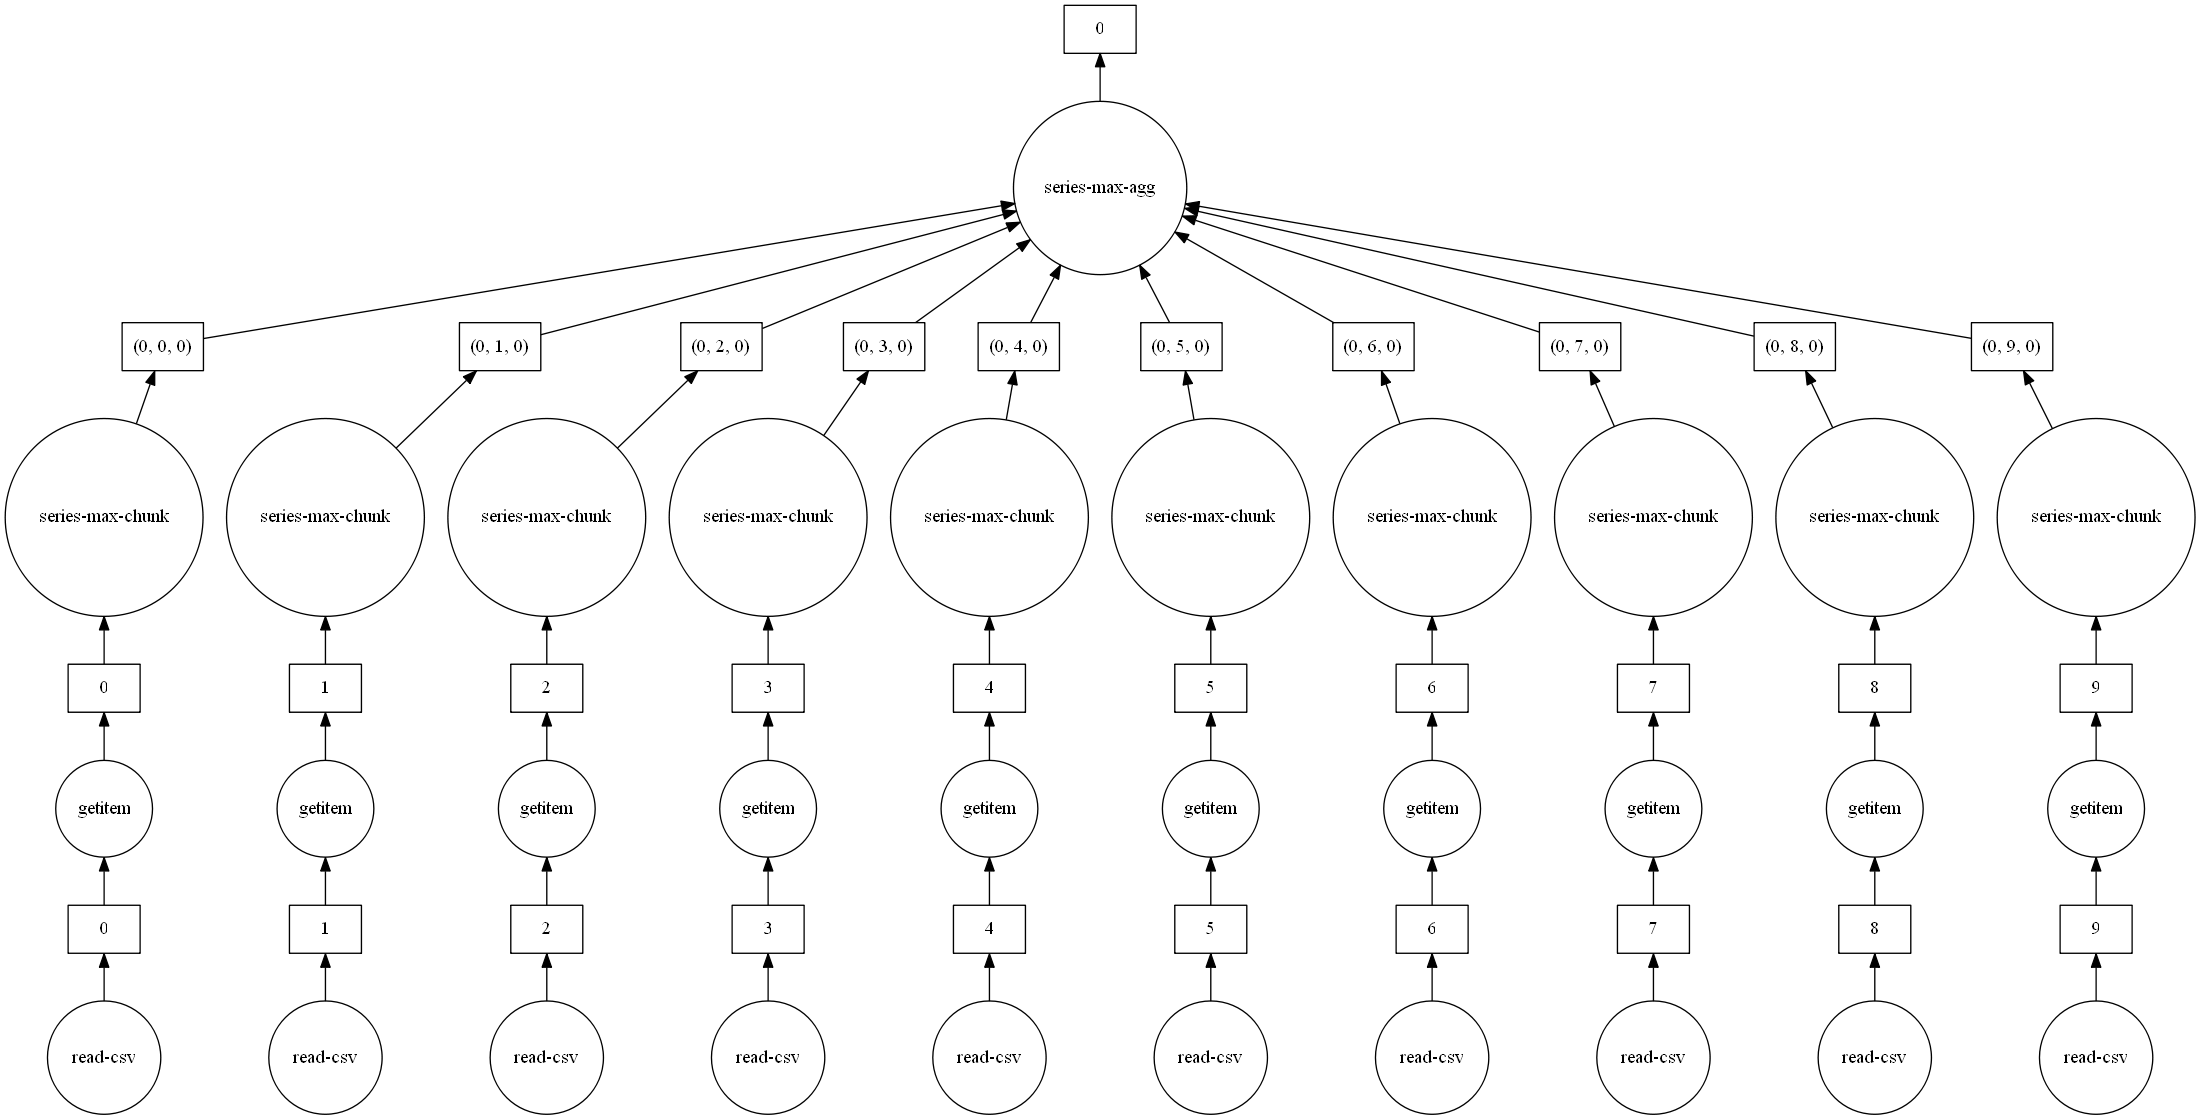

In [10]:
max_delay.visualize()

To evaluate the result for `max_delay`, call its `compute()` method:

In [11]:
%time max_delay.compute()

Wall time: 4.24 s


1435.0

This writes the delayed computation for us and then runs it.  

Some things to note:

1.  As with `dask.delayed`, we need to call `.compute()` when we're done.  Up until this point everything is lazy.
2.  Dask will delete intermediate results (like the full pandas dataframe for each file) as soon as possible.
    -  This lets us handle datasets that are larger than memory
    -  This means that repeated computations will have to load all of the data in each time (run the code above again, is it faster or slower than you would expect?)
    
As with `Delayed` objects, you can view the underlying task graph using the `.visualize` method:

# Exercises

In this section we do a few Dask DataFrame computations. If you are comfortable with Pandas, then these should be very familiar. You will have to think about when to call `compute`.

## Exercise 1: In total, how many non-canceled flights were taken?


In [21]:
# Your solution here
count_non_cancelled = (~df['Cancelled']).sum()

In [22]:
%time count_non_cancelled.compute()

Wall time: 4.15 s


2540961

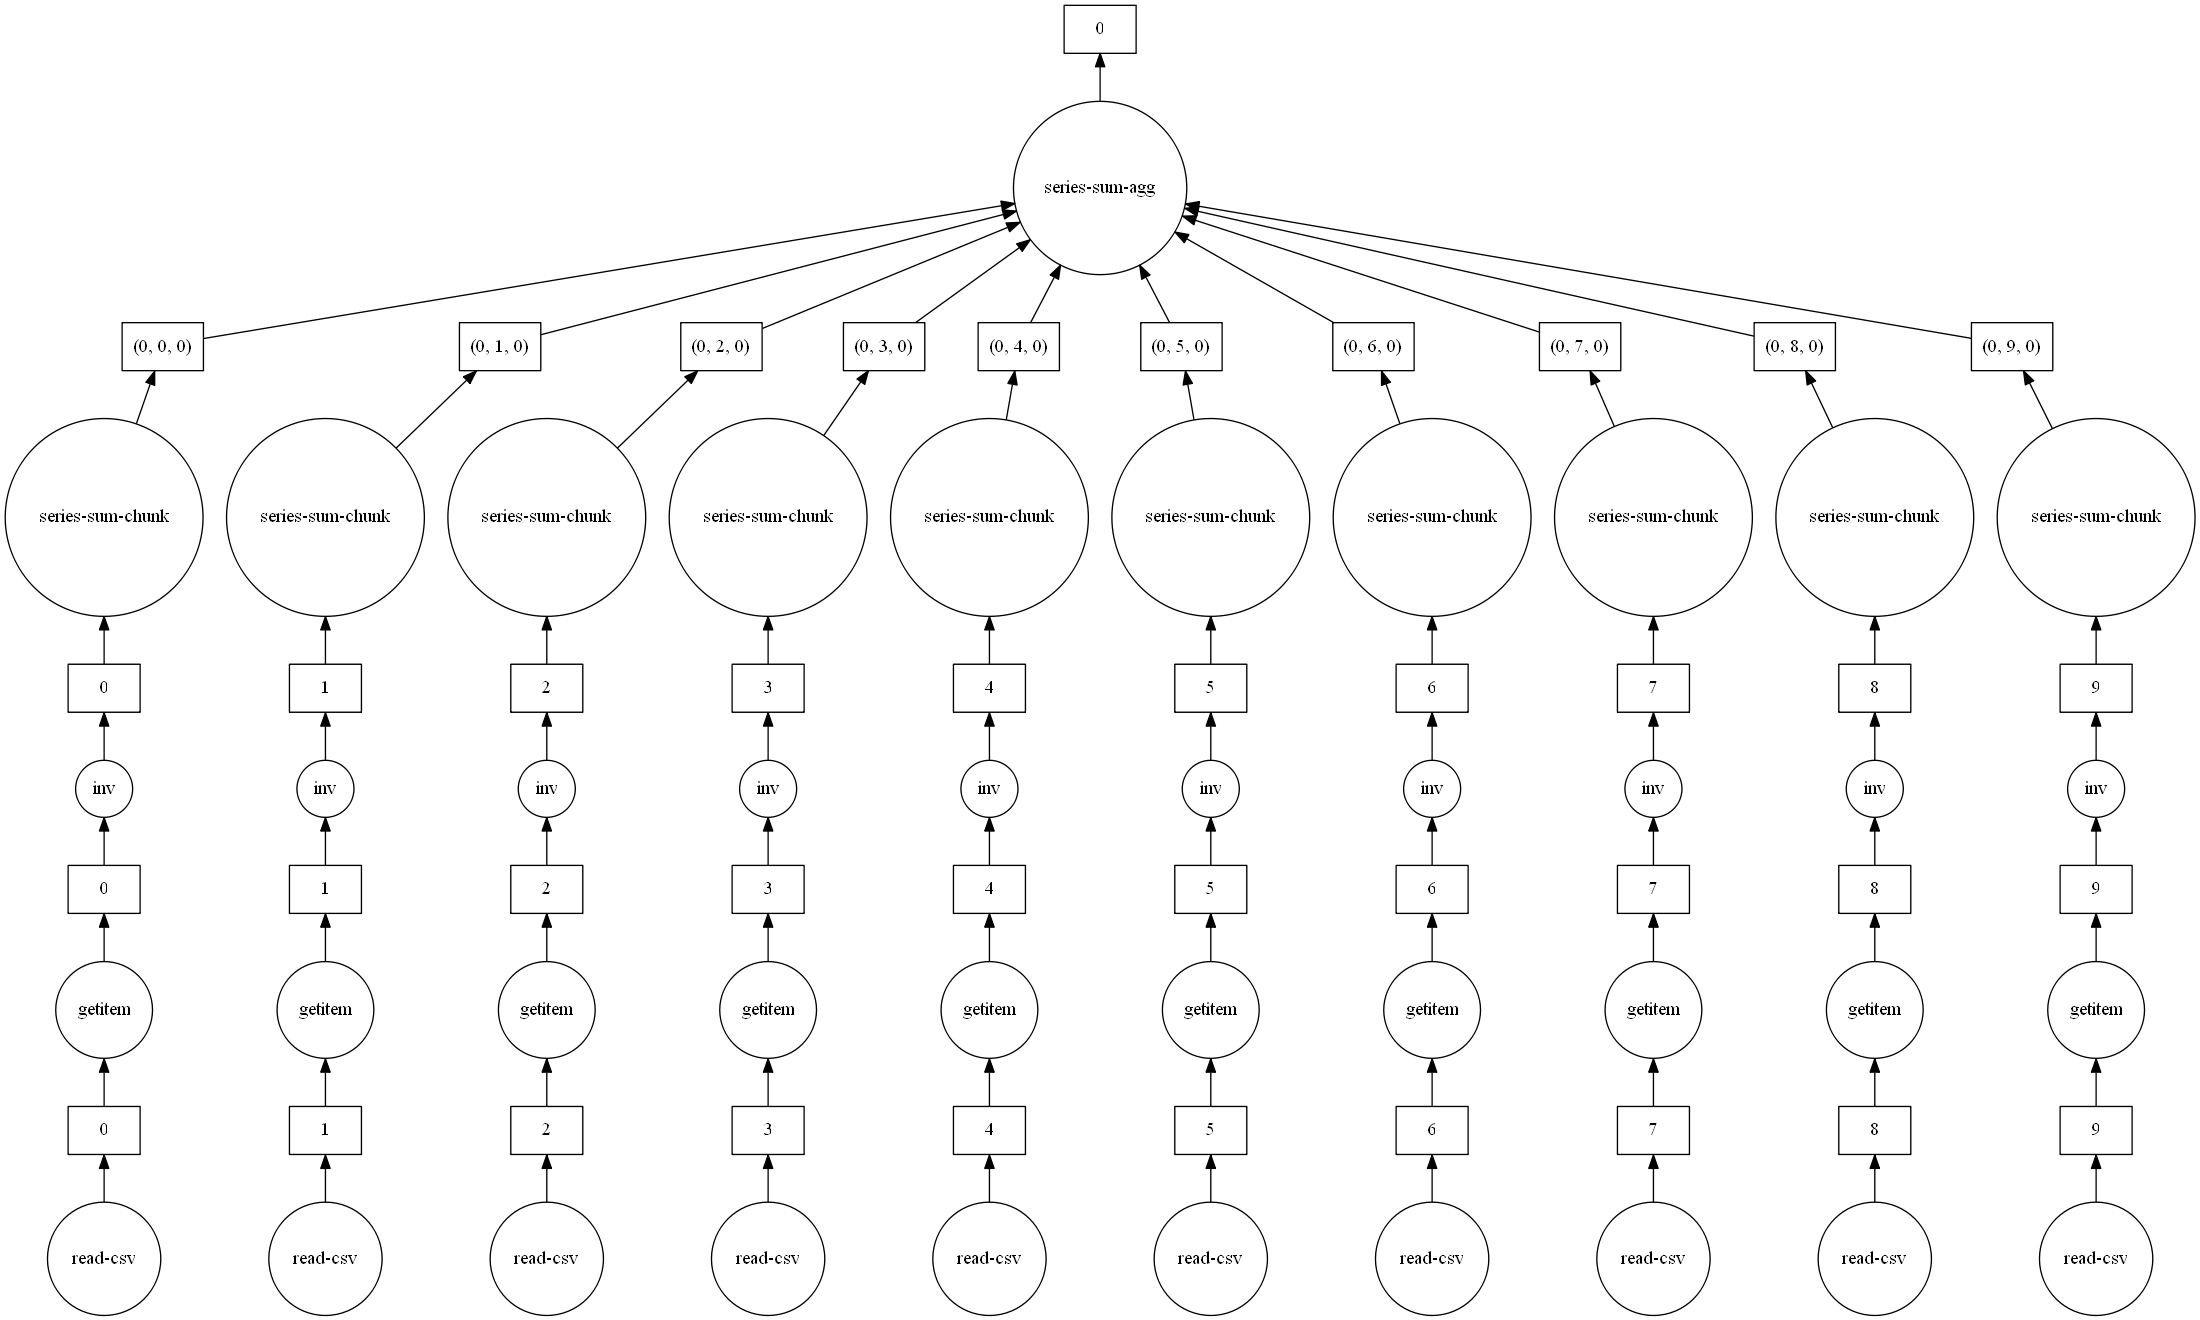

In [23]:
count_non_cancelled.visualize()

In [19]:
# %load solutions/dataframe-1.py
(~df["Cancelled"]).sum().compute()

2540961

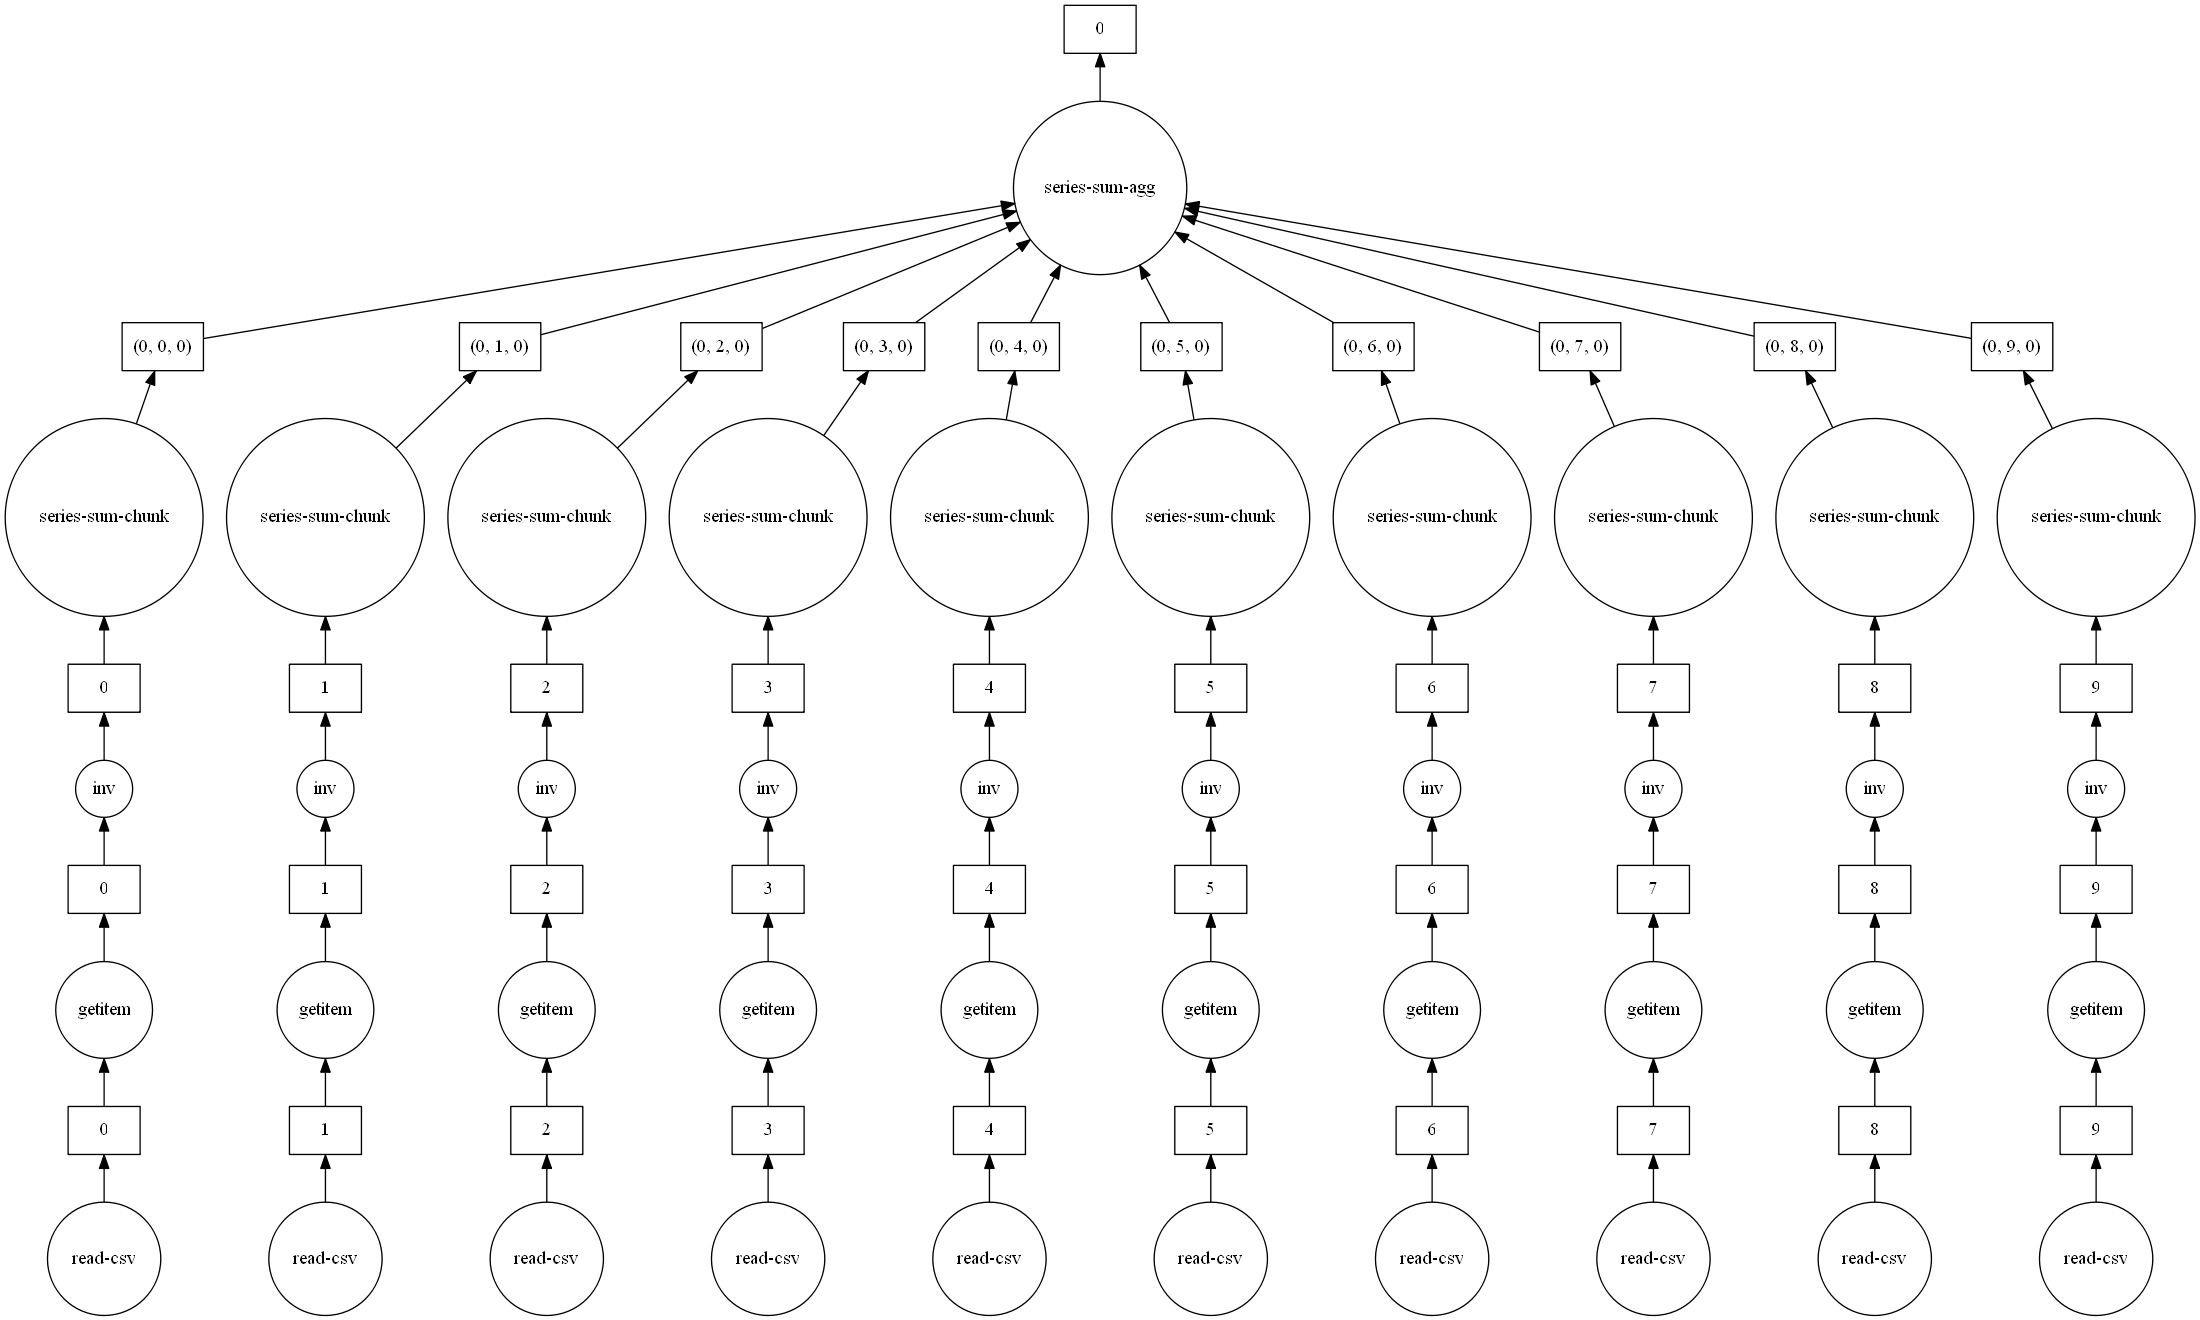

In [20]:
(~df["Cancelled"]).sum().visualize()

## Exercise 2: In total, how many non-cancelled flights were taken from each airport?

*Hint*: use [`df.groupby`](https://pandas.pydata.org/pandas-docs/stable/groupby.html).

In [45]:
# Your solution here
grouped = df[~df["Cancelled"]].groupby("Origin")
cancelled_by_airport = grouped.Origin.count()
%time cancelled_by_airport.compute()

Wall time: 4.63 s


Origin
EWR    1139451
JFK     427243
LGA     974267
Name: Origin, dtype: int64

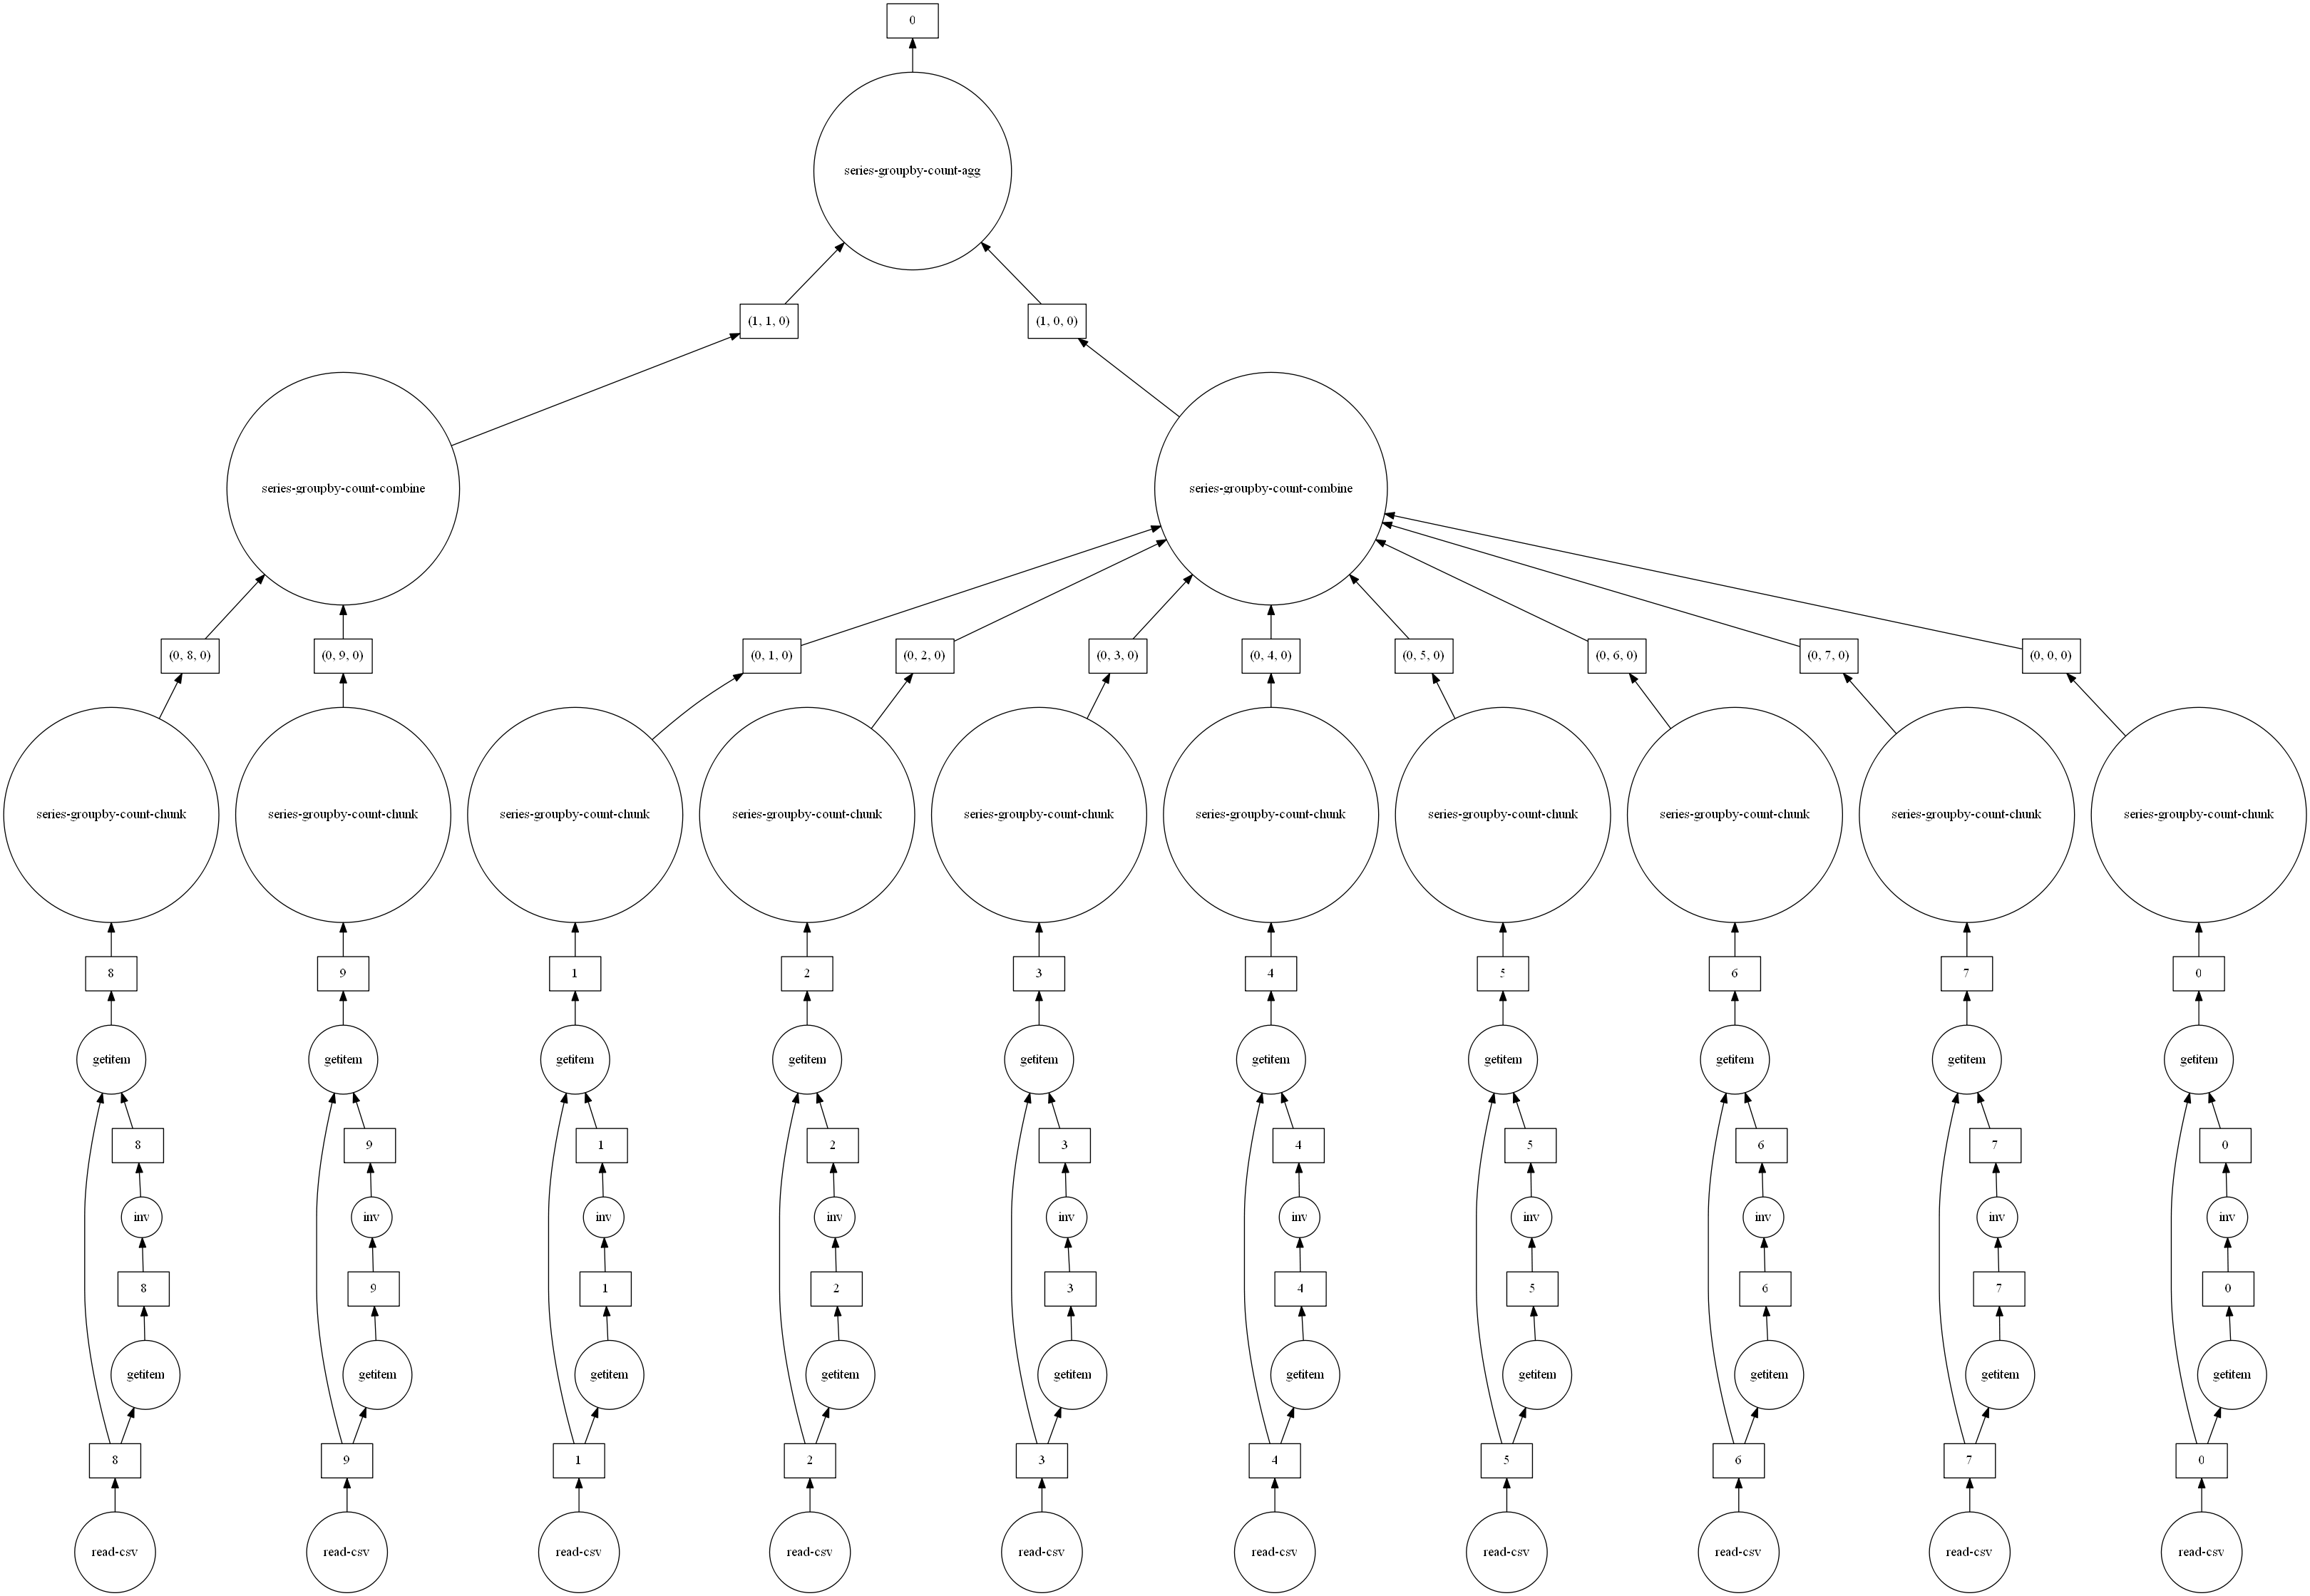

In [46]:
cancelled_by_airport.visualize()

In [44]:
# %load solutions/dataframe-2.py
df[~df["Cancelled"]].groupby("Origin").Origin.count().compute()

## Exercise 3: What was the average departure delay from each airport?

Note, this is the same computation you did in the previous notebook (is this approach faster or slower?)

In [47]:
# Your solution here
%time df.groupby("Origin").DepDelay.mean().compute()

Wall time: 4.93 s


Origin
EWR    10.295469
JFK    10.351299
LGA     7.431142
Name: DepDelay, dtype: float64

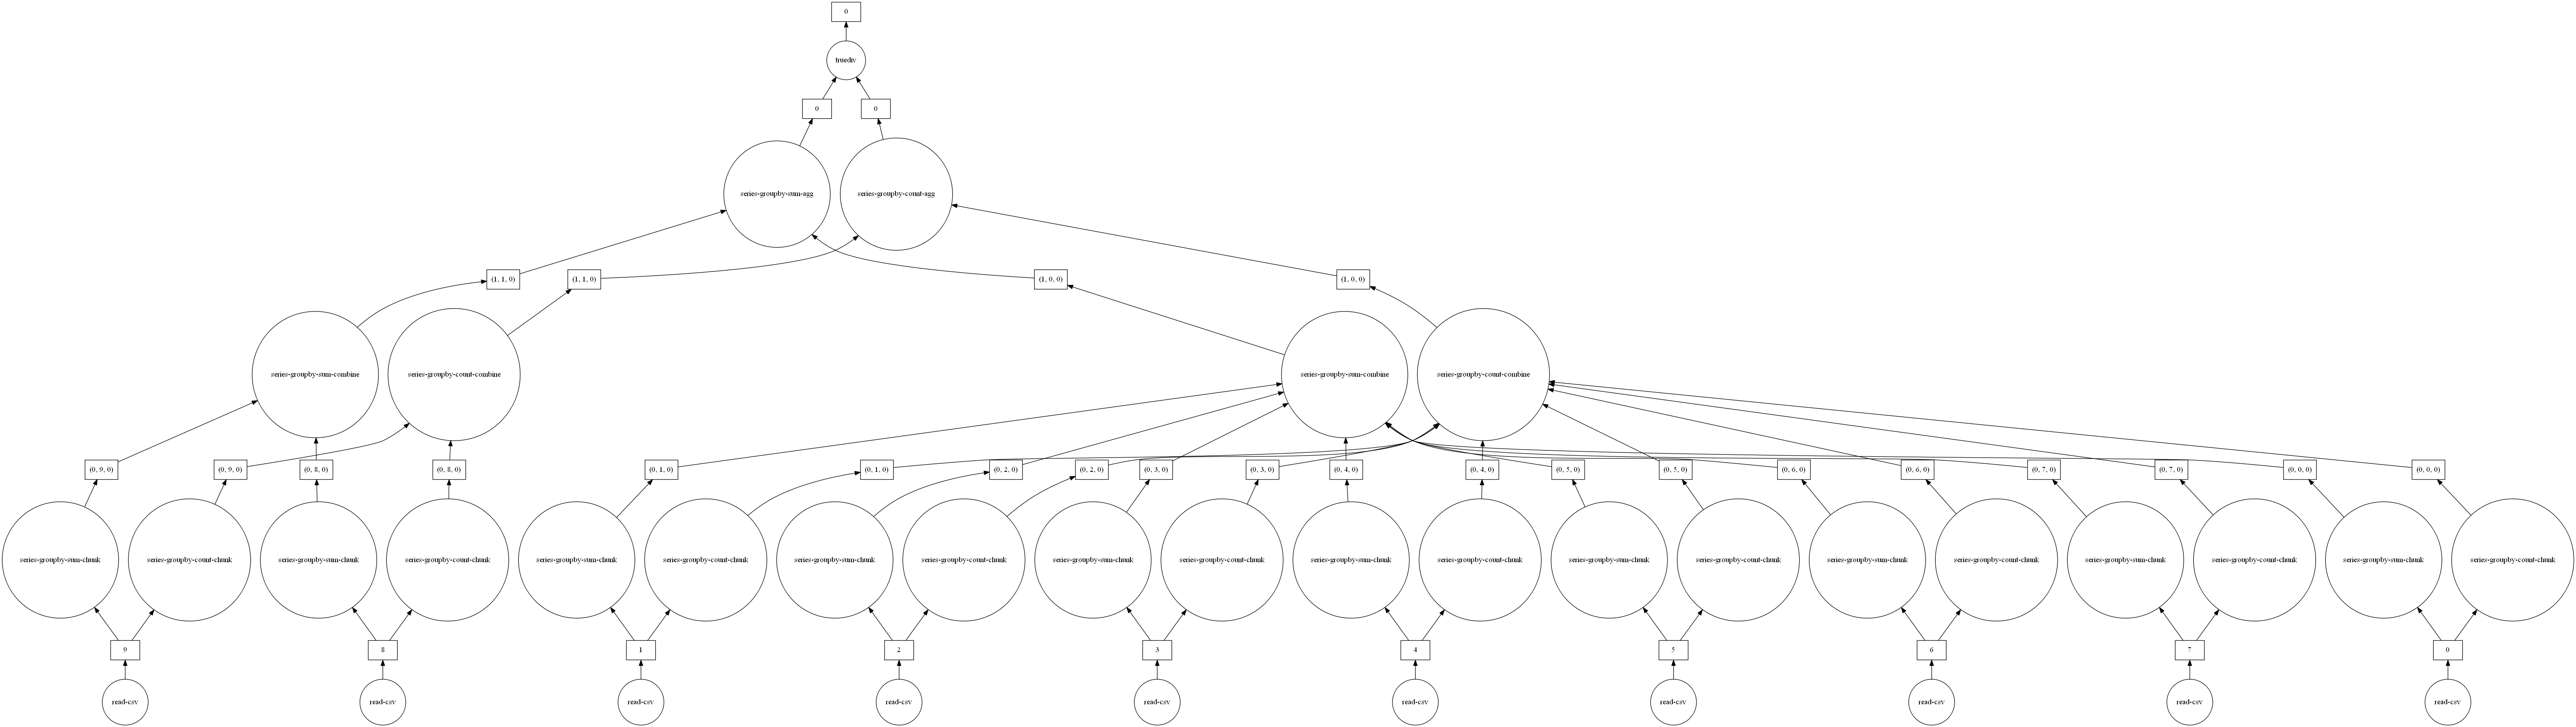

In [49]:
df.groupby("Origin").DepDelay.mean().visualize()

In [51]:
# %load solutions/dataframe-3.py
df.groupby("Origin").DepDelay.mean().compute()

## Exercise 4: What day of the week has the worst average departure delay?

In [56]:
# Your solution here
%time df.groupby('DayOfWeek').DepDelay.mean().idxmax().compute()

Wall time: 4.14 s


5

In [57]:
# %load solutions/dataframe-4.py
df.groupby("DayOfWeek").DepDelay.mean().idxmax().compute()

# Performance tip: Share intermediate results

When doing computations in the above exercises, we sometimes did the same operation more than once (e.g. `read_csv`). For most operations, Dask DataFrames hashes the arguments, allowing duplicate computations to be shared, and only computed once.

For example, let's compute the mean and standard deviation for departure delay of all non-canceled flights. Since Dask operations are lazy, those values aren't the final results yet. They're just the recipe required to get the result.

If we compute them with two calls to compute, there is no sharing of intermediate computations.

In [58]:
non_cancelled = df[~df["Cancelled"]]
mean_delay = non_cancelled["DepDelay"].mean()
std_delay = non_cancelled["DepDelay"].std()

In [59]:
%%time

mean_delay_result = mean_delay.compute()
std_delay_result = std_delay.compute()

Wall time: 9.79 s


Let's now try computing `mean_delay` and `std_delay` with a single `dask.compute` call.

In [60]:
import dask

%time mean_delay_res, std_delay_res = dask.compute(mean_delay, std_delay)

Wall time: 4.7 s


Using `dask.compute` takes roughly 1/2 the time. This is because the task graphs for both results are merged when calling `dask.compute`, allowing shared operations (like `read_csv`) to only be done once instead of twice. In particular, using `dask.compute` only does the following once:

- The calls to `read_csv`
- The filter (`df[~df["Cancelled"]]`)
- The `"DepDelay"` column indexing
- Some of the necessary reductions (`sum`, `count`)

To see what the merged task graphs between multiple results look like (and what's shared), you can use the `dask.visualize` function:

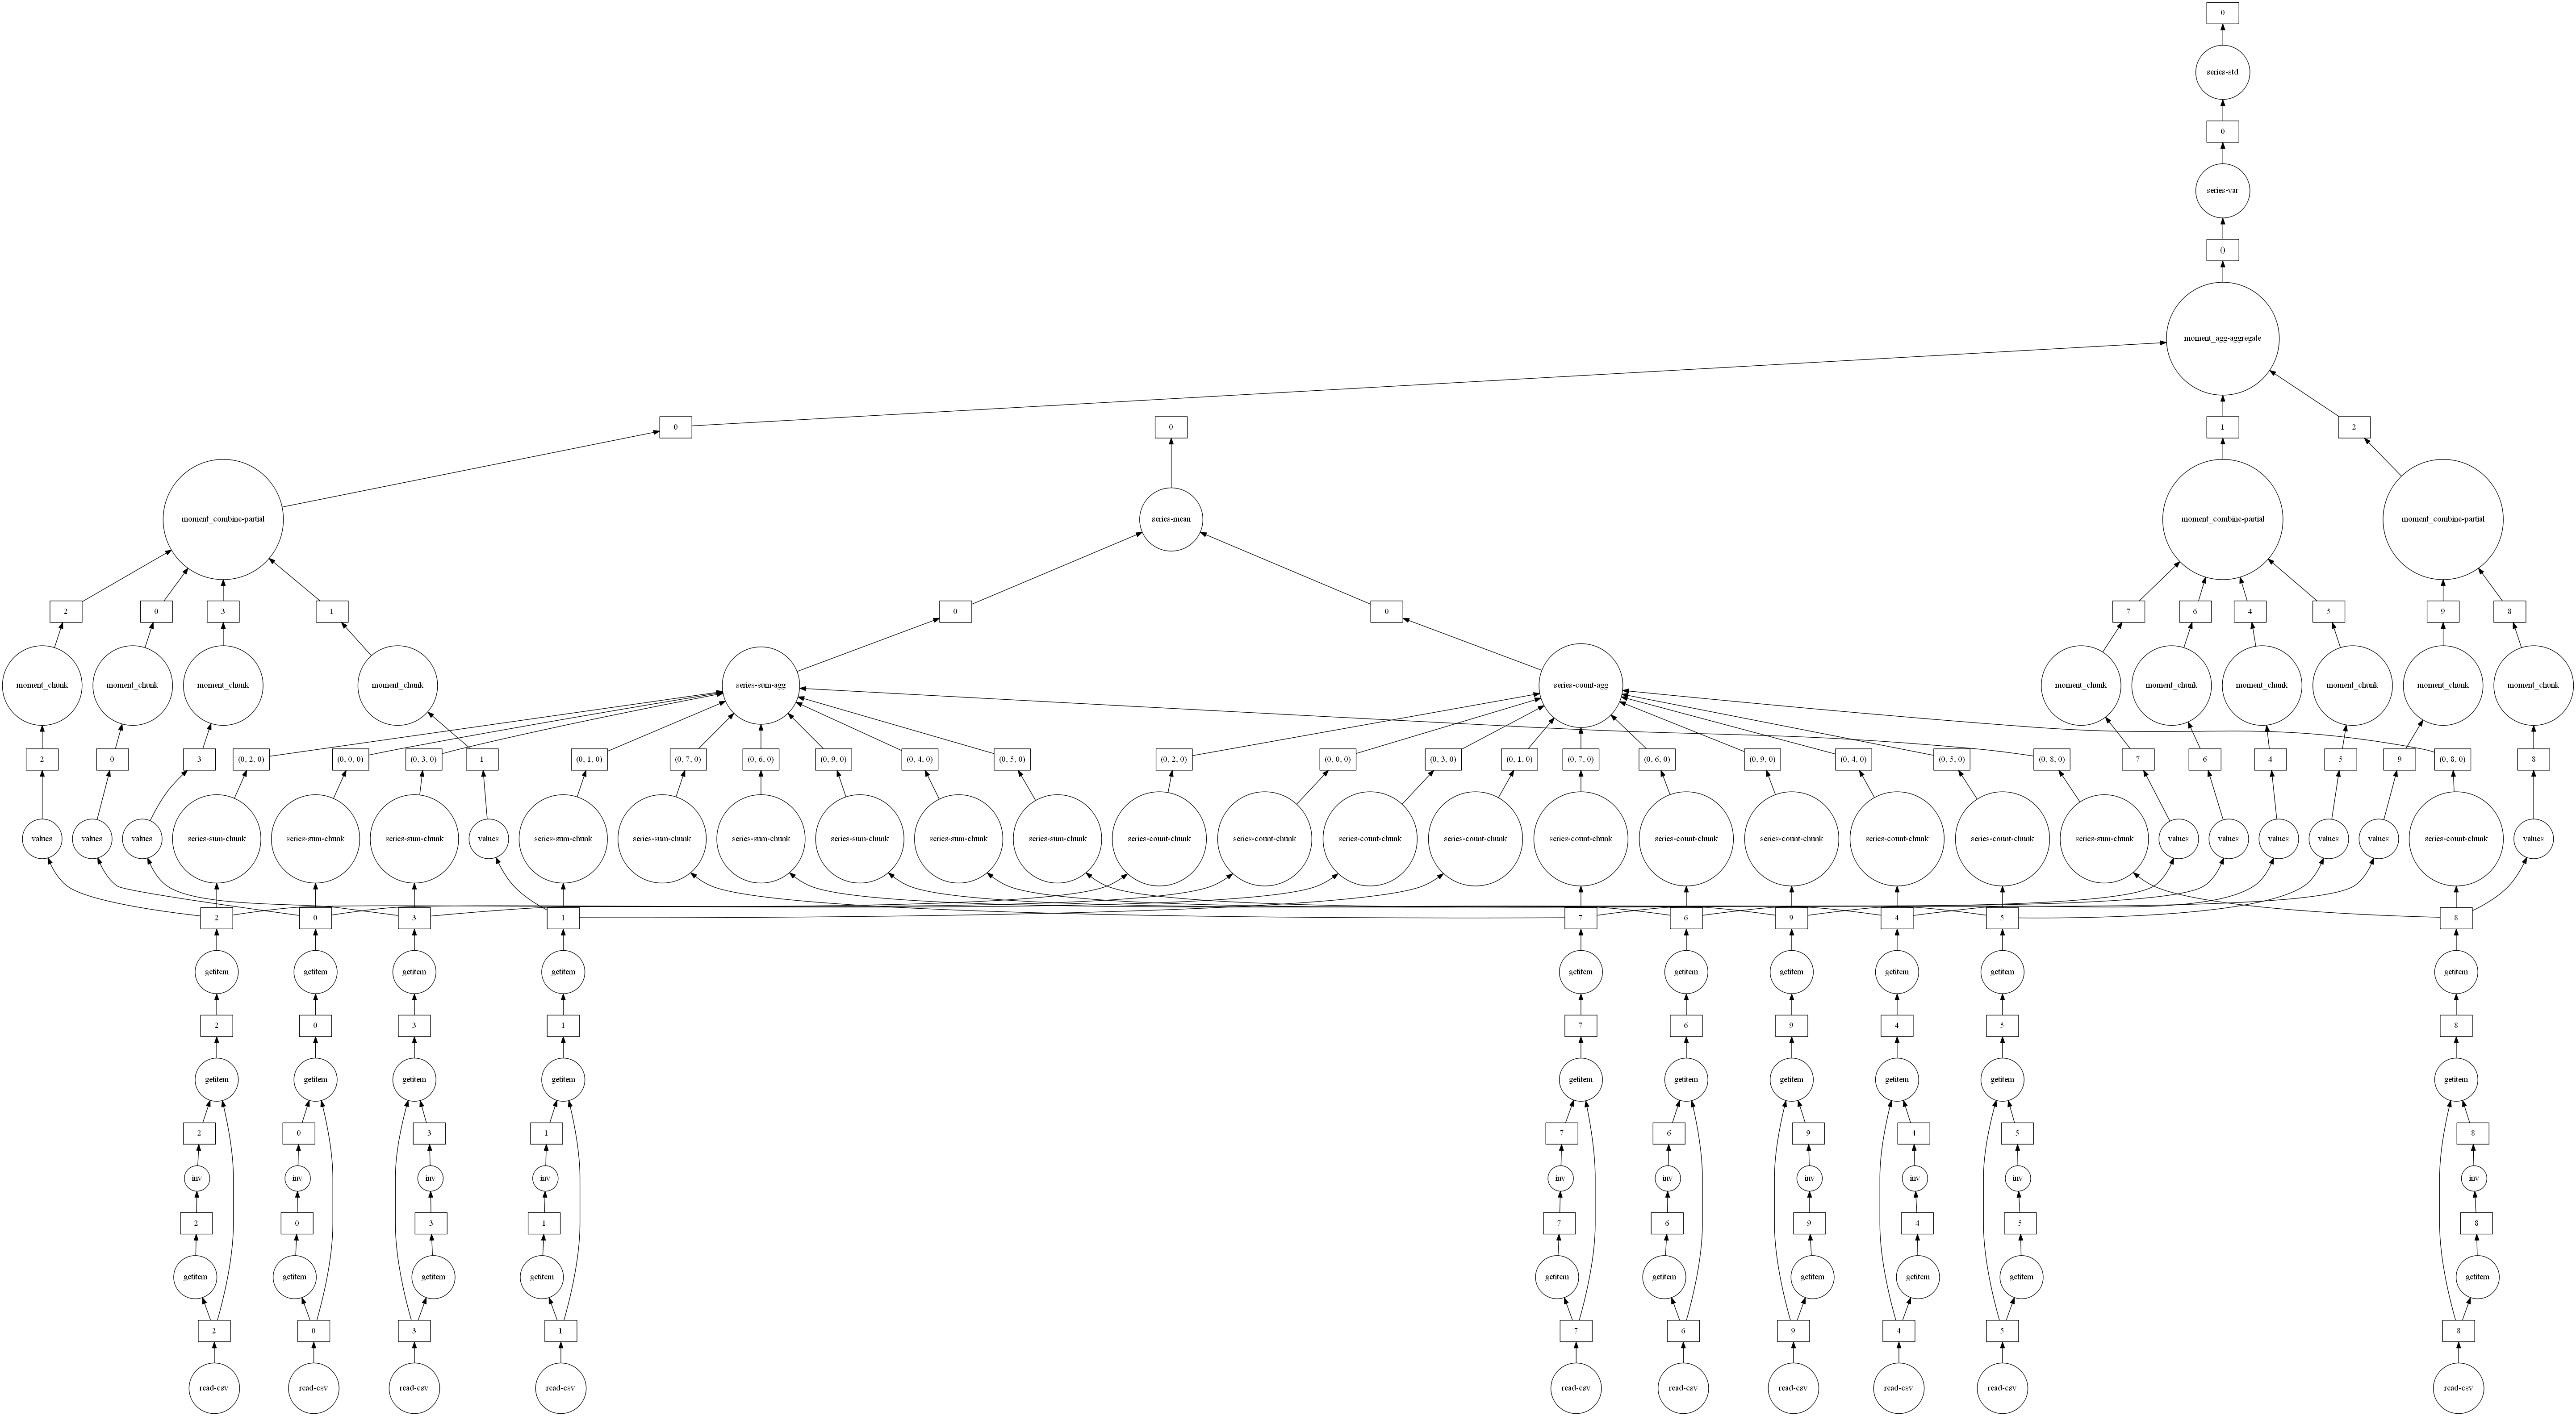

In [61]:
dask.visualize(mean_delay, std_delay)

# Applying custom code to Dask DataFrames:

This dataset stores timestamps as `HHMM`, which are read in as integers in `read_csv`:

In [62]:
crs_dep_time = df.CRSDepTime.head(10)
crs_dep_time

0    1540
1    1540
2    1540
3    1540
4    1540
5    1540
6    1540
7    1540
8    1540
9    1540
Name: CRSDepTime, dtype: int64

To convert these to timestamps of scheduled departure time, we need to convert these integers into `pd.Timedelta` objects, and then combine them with the `Date` column.

In pandas we'd do this using the `pd.to_timedelta` function, and a bit of arithmetic:

In [63]:
import pandas as pd

# Get the first 10 dates to complement our `crs_dep_time`
date = df.Date.head(10)

# Get hours as an integer, convert to a timedelta
hours = crs_dep_time // 100
hours_timedelta = pd.to_timedelta(hours, unit='h')

# Get minutes as an integer, convert to a timedelta
minutes = crs_dep_time % 100
minutes_timedelta = pd.to_timedelta(minutes, unit='m')

# Apply the timedeltas to offset the dates by the departure time
departure_timestamp = date + hours_timedelta + minutes_timedelta
departure_timestamp

0   1990-01-01 15:40:00
1   1990-01-02 15:40:00
2   1990-01-03 15:40:00
3   1990-01-04 15:40:00
4   1990-01-05 15:40:00
5   1990-01-06 15:40:00
6   1990-01-07 15:40:00
7   1990-01-08 15:40:00
8   1990-01-09 15:40:00
9   1990-01-10 15:40:00
dtype: datetime64[ns]

### Custom code and Dask Dataframe

We could swap out `pd.to_timedelta` for `dd.to_timedelta` and do the same operations on the entire dask DataFrame. But let's say that Dask hadn't implemented a `dd.to_timedelta` that works on Dask DataFrames. What would you do then?

Dask DataFrames have a few methods to make applying custom functions to Dask DataFrames easier:

- [`map_partitions`](http://dask.pydata.org/en/latest/dataframe-api.html#dask.dataframe.DataFrame.map_partitions)
- [`map_overlap`](http://dask.pydata.org/en/latest/dataframe-api.html#dask.dataframe.DataFrame.map_overlap)
- [`reduction`](http://dask.pydata.org/en/latest/dataframe-api.html#dask.dataframe.DataFrame.reduction)

Here we'll just be discussing `map_partitions`, which we can use to implement `to_timedelta` on our own:

In [64]:
# Look at the docs for `map_partitions`

df.CRSDepTime.map_partitions?

Signature: df.CRSDepTime.map_partitions(func, *args, **kwargs)
Docstring:
Apply Python function on each DataFrame partition.

Note that the index and divisions are assumed to remain unchanged.

Parameters
----------
func : function
    Function applied to each partition.
args, kwargs :
    Arguments and keywords to pass to the function. The partition will
    be the first argument, and these will be passed *after*. Arguments
    and keywords may contain ``Scalar``, ``Delayed`` or regular
    python objects. DataFrame-like args (both dask and pandas) will be
    repartitioned to align (if necessary) before applying the function.
meta : pd.DataFrame, pd.Series, dict, iterable, tuple, optional
    An empty ``pd.DataFrame`` or ``pd.Series`` that matches the dtypes
    and column names of the output. This metadata is necessary for
    many algorithms in dask dataframe to work.  For ease of use, some
    alternative inputs are also available. Instead of a ``DataFrame``,
    a ``dict`` of ``{

The basic idea is to apply a function that operates on a DataFrame to each partition.
In this case, we'll apply `pd.to_timedelta`.

In [65]:
hours = df.CRSDepTime // 100
# hours_timedelta = pd.to_timedelta(hours, unit='h')
hours_timedelta = hours.map_partitions(pd.to_timedelta, unit='h')

minutes = df.CRSDepTime % 100
# minutes_timedelta = pd.to_timedelta(minutes, unit='m')
minutes_timedelta = minutes.map_partitions(pd.to_timedelta, unit='m')

departure_timestamp = df.Date + hours_timedelta + minutes_timedelta

In [66]:
departure_timestamp

Dask Series Structure:
npartitions=10
    datetime64[ns]
               ...
         ...      
               ...
               ...
dtype: datetime64[ns]
Dask Name: add, 90 tasks

In [67]:
departure_timestamp.head()

0   1990-01-01 15:40:00
1   1990-01-02 15:40:00
2   1990-01-03 15:40:00
3   1990-01-04 15:40:00
4   1990-01-05 15:40:00
dtype: datetime64[ns]

## Exercise 5: Rewrite above to use a single call to `map_partitions`

This will be slightly more efficient than two separate calls, as it reduces the number of tasks in the graph.

In [75]:
# Your solution here

def compute_departure_timestamp(df):
    # TODO: implement this
    hours = (df.CRSDepTime // 100) * 60
    minutes = df.CRSDepTime % 100
    minutes_all = hours + minutes
    all_minutes_timedelta = pd.to_timedelta(minutes_all, unit='m')
    return df.Date + all_minutes_timedelta
    
departure_timestamp = df.map_partitions(compute_departure_timestamp)
departure_timestamp.head()

0   1990-01-01 15:40:00
1   1990-01-02 15:40:00
2   1990-01-03 15:40:00
3   1990-01-04 15:40:00
4   1990-01-05 15:40:00
dtype: datetime64[ns]

In [74]:
# %load solutions/dataframe-5.py
def compute_departure_timestamp(df):
    hours = df.CRSDepTime // 100
    hours_timedelta = pd.to_timedelta(hours, unit='h')

    minutes = df.CRSDepTime % 100
    minutes_timedelta = pd.to_timedelta(minutes, unit='m')

    return df.Date + hours_timedelta + minutes_timedelta

departure_timestamp = df.map_partitions(compute_departure_timestamp)
departure_timestamp.head()

0   1990-01-01 15:40:00
1   1990-01-02 15:40:00
2   1990-01-03 15:40:00
3   1990-01-04 15:40:00
4   1990-01-05 15:40:00
dtype: datetime64[ns]

# Additional Resources

* [DataFrame documentation](https://docs.dask.org/en/latest/dataframe.html)
* [DataFrame screencast](https://youtu.be/AT2XtFehFSQ)
* [DataFrame API](https://docs.dask.org/en/latest/dataframe-api.html)
* [DataFrame examples](https://examples.dask.org/dataframe.html)
* [Pandas documentation](https://pandas.pydata.org/pandas-docs/stable/)

# Next steps

Finally, we'll discuss [Dask's task schedulers](3-schedulers.ipynb) in the next notebook.